In [2]:
from __future__ import division
import numpy as np
import os, sys
import matplotlib
#matplotlib.use('Agg')
%matplotlib nbagg
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from collections import defaultdict, Counter
import pickle

def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

## Load consolidated data
### Cleanup
- remove those with missing query type entries
- remove entries with missing timing field
- remove those with invalid query types

In [102]:
df = pd.read_csv('../data/tshark_20170207_20170212_consolidated/split_hour_00000_20170206235900.csv',
                 names=['timestamp', 'time_relative', 'srcIP', 'dstIP', 'qname', 'qtype', 'macAddr', 'subnet', 'host_type', 
'host_name', 'system_type', 'OS', 'nic_manufacturer'])

print len(df)

# remove those with NaN in query type
df = df.dropna(subset=['qtype'])

1936754


In [103]:
# 244 entries contain invalid qtype and need to be cleaned up
# 144 of these seem to be from the same virtual machine source with IP 140.180.219.15 and have 2 dns query separated by a comma
# the rest seem to be querying '<Unknown extended label>' or have missing timestamp fileds and are VMs
df[ ~df['qtype'].str.contains('0x') ]

,timestamp,time_relative,srcIP,dstIP,qname,qtype,macAddr,subnet,host_type,host_name,system_type,OS,nic_manufacturer
4666,1.48644e+09,7.1883,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
4960,1.48644e+09,7.59091,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
5261,1.48644e+09,8.17301,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
5272,1.48644e+09,8.18228,10.8.147.162,104.192.108.153,<Unknown extended label>,<Unknown extended label>,<Unknown extended label>,<Unknown extended label>,0x00006546,0x00005169,0x0000aa48,0x00007a47,NaN
11366,1.48644e+09,19.2461,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
11560,1.48644e+09,19.5395,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
56948,1.48644e+09,87.0393,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
57143,1.48644e+09,87.3367,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
57369,1.48644e+09,87.7473,140.180.219.15,128.112.133.220,outlook.office365.com,outlook.office365.com,0x00000001,0x0000001c,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc
64447,1.48644e+09,99.5771,10.8.162.118,104.192.108.117,<Unknown extended label>,<Unknown extended label>,0x00007924,0x00006ac9,NaN,vapornet100,host-dynamic,nat-oitwireless-inside-vapornet100-b-8812,NaN


In [104]:
# clean up data based on valid query types
df = df[ df['qtype'].str.contains('0x') ]

In [105]:
print "total valid queries =", len(df)

total valid queries = 1935015


### dtype conversions

In [106]:
# convert timestamps to float
df[['timestamp', 'time_relative']] = df[['timestamp', 'time_relative']].apply(pd.to_numeric, errors='coerce')

# convert qtype (A, CNAME) from hex to int
df['qtype'] = df['qtype'].apply(lambda x: int( x.split(',')[0], 16))

# lower case all dns queries
df['qname'] = df['qname'].str.lower()


In [110]:
dnstype_count = df.groupby('qtype')['qname'].count()
dnstype_count.sort_values(inplace=True, ascending=False)

print "Percentage of A Records in data = ", dnstype_count.iloc[0]/dnstype_count.sum()*100

dnstype_count.head(15)

Percentage of A Records in data =  77.8253915344


qtype
1        1505933
28        196059
12        153732
15         37187
33         33905
16          3572
6           3331
43           500
255          319
249          185
2            110
46879         36
41503         14
41247         11
14270          6
Name: qname, dtype: int64

## 1. Filter to A records only

In [112]:
df_a = (df[df.qtype == 1]).copy()

## Add 1LD and 2LD as column

In [115]:
def reduce_domain(domain, level):
    tmp = domain.split('.')
    out = '.'.join( tmp[-level:] )
    return out
    
print reduce_domain('www.youtube.com', 2)
print reduce_domain('www.youtube.com', 1)

youtube.com
com


In [118]:
df_a['1LD'] = df_a['qname'].apply(lambda x: reduce_domain(x, 1))
df_a['2LD'] = df_a['qname'].apply(lambda x: reduce_domain(x, 2))

## 2. Filter out PRINCETON.EDU

In [120]:
df_b = df_a[ df_a['2LD'] != 'princeton.edu' ]
print len(df_a), len(df_b)

1505933 1357654


## Extract srcIP unique features (to act as confirmation of Ground Truth)
- group by source IP as key
- Check if ['macAddr', 'subnet', 'host_type', 'host_name', 'system_type', 'OS', 'nic_manufacturer'] remain the same for each source IP after grouping

In [127]:
check_uniqueness = df_b.groupby('srcIP')[['macAddr', 'subnet', 'host_type', 'host_name', 'system_type',
                                          'OS', 'nic_manufacturer']].aggregate(lambda x: len(set(x)))

check_uniqueness[check_uniqueness['macAddr'] > 1]

,macAddr,subnet,host_type,host_name,system_type,OS,nic_manufacturer
srcIP,,,,,,,


In [131]:
srcIP_groundtruth = df_b.groupby('srcIP')[['macAddr', 'subnet', 'host_type', 'host_name', 'system_type',
                                          'OS', 'nic_manufacturer']].first()
srcIP_groundtruth.head()

,macAddr,subnet,host_type,host_name,system_type,OS,nic_manufacturer
srcIP,,,,,,,
10.6.48.10,b8:ca:3a:6e:ec:58,fw-servernet-2,host,win04,dell-pc,ms-windows-2012,Dell
10.6.48.100,0:50:56:93:8:e,fw-servernet-2,host,dev-webqa,virtual-machine,ms-windows-2012,Vmware
10.6.48.105,0:50:56:93:7f:61,fw-servernet-2,host,sdpvm200w,virtual-machine,ms-windows-2012,Vmware
10.6.48.112,0:50:56:93:6a:6,fw-servernet-2,host,spcacs201w,virtual-machine,ms-windows-2012,Vmware
10.6.48.116,0:50:56:93:68:af,fw-servernet-2,host,socopm100w,virtual-machine,ms-windows-2008,Vmware


## Extract Features from rest of data with key=srcIP
- only use relevant colums 'timestamp', 'time_relative', 'srcIP', 'dstIP', 'qname', '1LD', '2LD'

In [137]:
df_c = df_b[['timestamp', 'time_relative', 'srcIP', 'dstIP', 'qname', '1LD', '2LD']]
grouped = df_c.groupby('srcIP')

In [145]:
# grouped.agg({'C' : np.sum, 'D' : lambda x: np.std(x, ddof=1)})
data = defaultdict(list)

for srcip, group in grouped:
    # key
    data['srcIP'].append( srcip )
    
    # DSTIP
    # number of unique dstip
    data['dstIP.count'].append( len( set( group['dstIP'] ) ) )
    
    # most common dstip
    data['dstIP.most_popular'].append( Counter( group['dstIP'] ).most_common(1)[0][0] )
    
    # DNS QRY
    # count of total domains
    data['qname.count'].append( group['qname'].count() )
    
    # count of unique domains
    data['qname.unique.count'].append( len( set( group['qname'] )) )
    
    # count of unique 1LDs
    data['1LD.unique.count'].append( len( set( group['1LD'] )) )
    # count of unique 2LDs
    data['2LD.unique.count'].append( len( set( group['2LD'] )) )
    
    # TIME DIFF ALL - DESCRIBE
    td = group['timestamp'].diff()  #fold(1)
    data['time_diff.mean'].append( td.mean() )
    data['time_diff.std'].append( td.std() )
    data['time_diff.min'].append( td.min() ) 
    data['time_diff.max'].append( td.max() )
    data['time_diff.median'].append( td.median() )
    
    # TOP 3 most popular domains and their time diffs
    top3 = Counter( group['qname'] ).most_common(3)
    for num in range(3):
        column_name = 'qname.most_pop'+ str(num)
        
        if len(top3)>num:
            pop_domains = top3[num]
            domain = pop_domains[0]  #domain
            occurance = pop_domains[1]   #number of lookups
            data[column_name + '.domain'].append( domain )   
            data[column_name + '.count'].append( occurance )
            # time diff
            td = group[ group['qname']==domain ]['timestamp'].diff()
            data[column_name + '.time_diff.mean'].append( td.mean() )
            data[column_name + '.time_diff.std'].append( td.std() )
            data[column_name + '.time_diff.min'].append( td.min() )
            data[column_name + '.time_diff.max'].append( td.max() )
            data[column_name + '.time_diff.median'].append( td.median() )
            
        else:
            data[column_name + '.domain'].append( np.nan )   
            data[column_name + '.count'].append( np.nan )
            # time diff
            data[column_name + '.time_diff.mean'].append( np.nan )
            data[column_name + '.time_diff.std'].append( np.nan )
            data[column_name + '.time_diff.min'].append( np.nan )
            data[column_name + '.time_diff.max'].append( np.nan )
            data[column_name + '.time_diff.median'].append( np.nan )
            
    # Least popular domain
    bottom = Counter( group['qname'] ).most_common()[-1]
    data['qname.least_pop.domain'].append( bottom[0] )    #domain
    data['qname.least_pop.count'].append( bottom[1] )     #occurances

    # FREQUENCY BASED FEATURES
    # TODO only for background data

In [146]:
# check num entries before converting to dataframe
for k,v in data.items():
    print len(v), "\t", k

9019 	dstIP.most_popular
9019 	qname.most_pop2.count
9019 	qname.most_pop0.time_diff.median
9019 	qname.most_pop1.count
9019 	1LD.unique.count
9019 	time_diff.median
9019 	qname.unique.count
9019 	qname.most_pop0.time_diff.mean
9019 	qname.most_pop0.count
9019 	qname.most_pop2.time_diff.median
9019 	qname.most_pop1.time_diff.min
9019 	qname.most_pop2.time_diff.min
9019 	2LD.unique.count
9019 	qname.most_pop2.time_diff.std
9019 	qname.least_pop.count
9019 	time_diff.std
9019 	qname.most_pop1.time_diff.mean
9019 	qname.most_pop1.time_diff.std
9019 	qname.most_pop0.time_diff.std
9019 	qname.most_pop2.domain
9019 	qname.most_pop0.time_diff.min
9019 	srcIP
9019 	time_diff.max
9019 	time_diff.mean
9019 	qname.most_pop1.domain
9019 	qname.most_pop0.domain
9019 	qname.count
9019 	qname.most_pop0.time_diff.max
9019 	dstIP.count
9019 	time_diff.min
9019 	qname.most_pop1.time_diff.max
9019 	qname.most_pop1.time_diff.median
9019 	qname.least_pop.domain
9019 	qname.most_pop2.time_diff.mean
9019 	qn

In [147]:
df_features = pd.DataFrame(data)
df_features.head()

,1LD.unique.count,2LD.unique.count,dstIP.count,dstIP.most_popular,qname.count,qname.least_pop.count,qname.least_pop.domain,qname.most_pop0.count,qname.most_pop0.domain,qname.most_pop0.time_diff.max,...,qname.most_pop2.time_diff.median,qname.most_pop2.time_diff.min,qname.most_pop2.time_diff.std,qname.unique.count,srcIP,time_diff.max,time_diff.mean,time_diff.median,time_diff.min,time_diff.std
0,3,17,1,128.112.129.32,82,1,www.google.com,12,e1863.dspb.akamaiedge.net,826.509368,...,225.109573,5.840552,458.755275,23,10.6.48.10,226.720494,42.408970,27.007246,0.017376,50.710004
1,1,1,1,128.112.128.1,6,1,vortex-win.data.microsoft.com,5,settings-win.data.microsoft.com,964.020238,...,NaN,NaN,NaN,2,10.6.48.100,964.020238,584.807132,963.999243,0.000284,519.369585
2,1,1,1,128.112.128.1,1,1,dns.msftncsi.com,1,dns.msftncsi.com,NaN,...,NaN,NaN,NaN,1,10.6.48.105,NaN,NaN,NaN,NaN,NaN
3,1,2,1,128.112.128.1,12,1,go.microsoft.com,6,statsfe2.update.microsoft.com,541.406385,...,NaN,NaN,NaN,3,10.6.48.112,541.365839,262.413738,180.582701,76.617629,193.950951
4,1,2,1,128.112.128.1,2,1,ctldl.windowsupdate.com,1,crl.microsoft.com,NaN,...,NaN,NaN,NaN,2,10.6.48.116,0.009410,0.009410,0.009410,0.009410,NaN


## 3. FILTER devices with <=10 unique 2LDs

In [148]:
df_filtered1 = df_features[(df_features['2LD.unique.count']<=10)]

print len(df_filtered1)

4037


## 4. FILTER devices with >10 total queries throughout the 1 hour pcap

In [149]:
df_filtered2 = df_filtered1[(df_filtered1['qname.count']>10)]

print len(df_filtered2)

2223


## Set key as srcIP and join with srcIP_groundtruth table

In [153]:
df_full = df_filtered2.reset_index().set_index('srcIP').join(srcIP_groundtruth)
del df_full['index']

In [161]:
df_full.head()

,1LD.unique.count,2LD.unique.count,dstIP.count,dstIP.most_popular,qname.count,qname.least_pop.count,qname.least_pop.domain,qname.most_pop0.count,qname.most_pop0.domain,qname.most_pop0.time_diff.max,...,time_diff.median,time_diff.min,time_diff.std,macAddr,subnet,host_type,host_name,system_type,OS,nic_manufacturer
srcIP,,,,,,,,,,,,,,,,,,,,,
10.6.48.112,1,2,1,128.112.128.1,12,1,go.microsoft.com,6,statsfe2.update.microsoft.com,541.406385,...,180.582701,76.617629,193.950951,0:50:56:93:6a:6,fw-servernet-2,host,spcacs201w,virtual-machine,ms-windows-2012,Vmware
10.6.48.13,2,7,2,128.112.128.1,105,1,go.microsoft.com,28,clients1.google.com,180.060638,...,29.255084,0.003357,35.207985,0:50:56:93:5e:54,fw-servernet-2,host,essconsole200w,virtual-machine,ms-windows-2012,Vmware
10.6.48.14,1,1,1,128.112.128.1,131,131,endpoint.ingress.rapid7.com,131,endpoint.ingress.rapid7.com,40.077696,...,20.093167,10.030509,12.012770,0:50:56:93:5e:45,fw-servernet-2,host,ess-2008r2test,virtual-machine,ms-windows-2008,Vmware
10.6.48.148,2,4,2,128.112.128.1,24,3,dns.msftncsi.com,6,statsfe2.update.microsoft.com,601.741539,...,131.192425,0.024489,131.158580,0:50:56:93:17:5f,fw-servernet-2,host,ss220w,virtual-machine,ms-windows-2012,Vmware
10.6.48.160,1,1,2,128.112.129.7,12,12,linux-update.oracle.com,12,linux-update.oracle.com,45.112617,...,15.001348,0.000710,20.221434,0:50:56:93:5d:c3,fw-servernet-2,host,ais104l,virtual-machine,linux,Vmware


## 5. FILTER based on host_type and system_type
- system_type != virtual-machine

In [158]:
vms = df_full[df_full['system_type']=='virtual-machine']
print len(vms)

122


In [159]:
df_hosts = df_full[df_full['system_type']!='virtual-machine']

In [163]:
df_wireless = df_hosts[df_hosts['host_type']=='host-dynamic']
df_wired = df_hosts[df_hosts['host_type']!='host-dynamic']

print len(df_wired), len(df_wireless)

9 2092


In [164]:
df_wired

,1LD.unique.count,2LD.unique.count,dstIP.count,dstIP.most_popular,qname.count,qname.least_pop.count,qname.least_pop.domain,qname.most_pop0.count,qname.most_pop0.domain,qname.most_pop0.time_diff.max,...,time_diff.median,time_diff.min,time_diff.std,macAddr,subnet,host_type,host_name,system_type,OS,nic_manufacturer
srcIP,,,,,,,,,,,,,,,,,,,,,
10.6.48.62,1,1,2,128.112.129.7,12,12,linux-update.oracle.com,12,linux-update.oracle.com,18.000263,...,15.001484,0.001044,7.236358,0:50:56:93:72:39,fw-servernet-2,host,devrtools,dell-pc,linux,Vmware
10.6.49.1,2,8,1,128.112.128.1,50,1,clients2.google.com,10,clients2.googleusercontent.com,584.209087,...,39.639565,0.002616,80.158844,ec:f4:bb:e5:ae:78,fw-servernet-2,host,essconsole201w,dell-pc,ms-windows-2012,Dell
10.6.49.172,1,2,1,128.112.129.111,175,12,g4t2482g.houston.hp.com,79,storage-support.glb.itcs.hpe.com,60.008996,...,0.095821,0.003952,28.022075,0:50:56:0:7:77,fw-servernet-2,host,esshp-sp100,other,unknown,Vmware
10.6.52.121,1,1,2,128.112.129.7,12,12,feeds.travel.state.gov,12,feeds.travel.state.gov,160.021907,...,0.002988,0.000618,63.535062,24:6e:96:39:94:fe,fw-servernet-3,host,essesx213v-stonesoft,dell-pc,vmware-esx,Dell
10.6.52.125,3,3,2,128.112.129.7,31,1,ftp.ecsi.net,18,www.concursolutions.com,315.553191,...,74.900722,0.000923,107.992550,bc:30:5b:ef:a6:fe,fw-servernet-3,host,essesx214v-stonesoft,dell-pc,vmware-esx,Dell
10.6.63.102,1,1,2,128.112.129.7,24,24,linux-update.oracle.com,24,linux-update.oracle.com,45.082981,...,0.000291,0.000011,13.187051,ec:f4:bb:d1:49:84,lb-servernet-10,host,sdpldap101l,dell-pc,linux,Dell
140.180.219.15,1,1,1,128.112.133.220,147,147,outlook.office365.com,147,outlook.office365.com,305.171067,...,0.650094,0.000017,49.595754,0:c:29:ba:8a:c1,fw-servernet-7,host,uc-cuc-p01,other-pc,unknown,Vmware
172.20.50.101,2,2,1,10.6.48.144,214,8,3.debian.pool.ntp.org,182,smtp.office365.com,120.728163,...,0.002637,0.000009,39.616969,b8:27:eb:f1:b:fd,basnet,host,fac-eng-ledsense-tigw59,n/a,n/a,Raspberr
172.20.50.102,2,2,1,10.6.48.144,214,8,3.debian.pool.ntp.org,182,smtp.office365.com,120.619818,...,0.003446,0.000009,39.881540,b8:27:eb:19:a5:1f,basnet,host,fac-eng-ledsense-tigw72,n/a,n/a,Raspberr


In [166]:
len(df_wireless)

2092

In [167]:
df_wireless.subnet.unique()

array(['vapornet100'], dtype=object)

In [174]:
len( df_wireless[ df_wireless['macAddr'].isnull()] )

1443

In [168]:
df_wireless.nic_manufacturer.unique()

array([nan, 'Apple', 'GioneeCo', 'LiteonTe', 'IntelCor', 'SamsungE',
       'LgElectr', 'Microsof', 'MurataMa', 'XiaomiCo', 'Fn-LinkT',
       'Motorola', 'AmazonTe', 'HonHaiPr', 'HuaweiTe', 'TctMobil', 'Htc',
       'Barnes&N', 'Azurewav', 'ChiconyE', 'Private', 'BluProdu',
       'OneplusT', 'SonyMobi', 'Zte'], dtype=object)

## Summary of hosts
- df_wired contains 9 unique IPs.
    - 7 of these seem to be departmental computers on servernet subnet running linux, windows or VMware.
    - 2 IPs (172.20.50.101, 172.20.50.102) seem to be running raspberry pi systems in the engineering building performing the same number of queries to ntp.org and office365.com
- df_wireless contains 2092 unique IPs.
    - all of these are NATted over the vapornet100 subnet
    - 1443 of 2092 IPs do not have a corresponding DHCP entry containing MAC address

## Analyzing wireless hosts
- TODO: find periods for all domain queries for these hosts

In [179]:
df_wireless[['macAddr', 'nic_manufacturer', 'qname.count', 'qname.unique.count', '1LD.unique.count',
             '2LD.unique.count', 'qname.most_pop0.domain', 'qname.most_pop0.time_diff.mean', 'qname.most_pop0.time_diff.std' ]]

,macAddr,nic_manufacturer,qname.count,qname.unique.count,1LD.unique.count,2LD.unique.count,qname.most_pop0.domain,qname.most_pop0.time_diff.mean,qname.most_pop0.time_diff.std
srcIP,,,,,,,,,
10.8.0.150,NaN,NaN,90,11,2,4,www.microsoft.com,64.886963,59.696266
10.8.0.213,NaN,NaN,28,13,2,4,e6858.dsce9.akamaiedge.net,680.684199,449.206464
10.8.0.39,NaN,NaN,21,15,3,9,www.ipswitch.ourdvs.com,30.574247,1.828986
10.8.1.70,NaN,NaN,29,13,2,4,mqtt.c10r.facebook.com,169.258066,230.134497
10.8.1.83,NaN,NaN,11,5,1,2,bg1.v4.a.dl.ws.microsoft.com,26.694561,35.653175
10.8.1.86,0c:15:39:31:ef:67,Apple,42,18,2,9,mobile.l.google.com,309.295310,114.264816
10.8.10.12,NaN,NaN,31,12,1,2,guzzoni.apple.com,782.741916,275.814738
10.8.10.165,18:65:90:3b:d2:e2,Apple,37,30,4,10,p11-keyvalueservice.icloud.com,502.064034,NaN
10.8.10.226,NaN,NaN,22,20,2,6,time-ios.apple.com,2332.967142,NaN


# TODO: CLUSTERING
- timing features can't be used for different domains as it wouldn't make sense. At least should be the same 2LD.
- focus on extracting periods for all domains for the above 2092 IPs instead

# Extract period for all qnames
### changes in ALGO:
    (1) use min diff (x) greater than 1.0 and floored to integer
    (2) period should be at most dns_time/2 instead of tot_time/2;
    (3) make sure to convert timestamp to time_relative before binning or y will have too many zero values

In [284]:
from scipy.signal import periodogram
PLOT_FIG = True


def get_period(df_dev, srcIP):
    '''df_dev is dataframe with fields [['timestamp', 'qname']] for a particular srcIP'''
    # separate each dns timeseries
    # make sure that particular DNS is present in AT LEAST half the total pcap time before getting period


    time_arr = list( df_dev['timestamp'] )
    tot_time = time_arr[-1] - time_arr[0]
    print "srcIP = ", srcIP, "; tot_time = ", tot_time

    for query, d in df_dev.groupby('qname'):

        time_arr = list( d['timestamp'] )
        dns_time = time_arr[-1] - time_arr[0]
        
        print "\tqname = ", query,"; dns_time = ", dns_time, "; len(d) = ", len(d)

        period = np.nan
        
        # at least more than half has dns queries and at least 10 queries
        if (dns_time >= tot_time/2) and len(d) > 10:
            #period, f, Pxx_den, y = extract_period(list(d['time']))

            # make timestamp to time_relative before binning
            x = np.array( list(d['timestamp'] - time_arr[0]) )
            
            # find min diff but greater than 1.0s and floored to nearest int
            Ts = int( min(x for x in np.diff(x)/2 if x > 1.0) )
            
            #Ts = np.min( np.diff(x) )/2
            #if Ts < 1.0:
            #    Ts = 1.0
            
            fs = 1.0/Ts
            #print "Ts, fs = ", Ts, fs
            
            y = np.bincount((x/Ts).astype(int))

            f, Pxx_den = periodogram(y, fs)

            max_el = max([(v,i) for i,v in enumerate(Pxx_den)])
            period_freq = f[max_el[1]-1]
            period = 1.0 / period_freq 
            
            print "\t\tTs = ",Ts ,"; period_freq = ", period_freq, "; period = %.2f s"%period,"; dns_time/2 = ", dns_time/2
            
            #if (period <= tot_time/2):
            if (period > dns_time/2):
                period = np.nan
                
            if PLOT_FIG:
                plt.ioff()
                fig1, axarr = plt.subplots(2, figsize=(12,8))
                axarr[0].plot(range(len(y)), y, linestyle='None', marker='o', markersize=5)
                axarr[0].set_xlabel('timestamp/Ts (Ts = %.f)'%Ts)
                axarr[0].set_ylabel('num of DNS queries')
                axarr[0].set_ylim([0, max(y)+0.25])
                axarr[0].grid(True)

                axarr[1].plot(f, Pxx_den, linestyle='None', marker='x', markersize=5)
                axarr[1].set_xlabel('frequency [Hz]')
                axarr[1].set_ylabel('PSD [V**2/Hz]')
                axarr[1].grid(True)

                fig1.suptitle(srcIP + ', ' + query + ': period = ' + "%.2f s"%period)
                #fig1.show()

                directory = '../results/periodogram/split_hour_00000_20170206235900/'
                if not os.path.exists(directory):
                    os.makedirs(directory)
                print '\t\tsave fig to '+ directory + srcIP + '_' + query + '.png\n'
                fig1.savefig(directory + srcIP + '_' + query + '.png')
                
                #plt.close(fig1)
                
    return period

### Try on srcIP = 10.9.96.37 with most popular query to device-metrics-us.amazon.com and 12 unique qnames

In [274]:
df_try = df_b[df_b['srcIP']=='10.9.96.37']
print len(df_try), len(df_try['qname'].unique()), len(df_try['2LD'].unique())

29 12 6


Ts, fs =  43 0.0232558139535
	Ts =  43 ; period_freq =  0.00302023557838 ; period = 331.10 s ; dns_time/2 =  1650.02455747


<IPython.core.display.Javascript object>


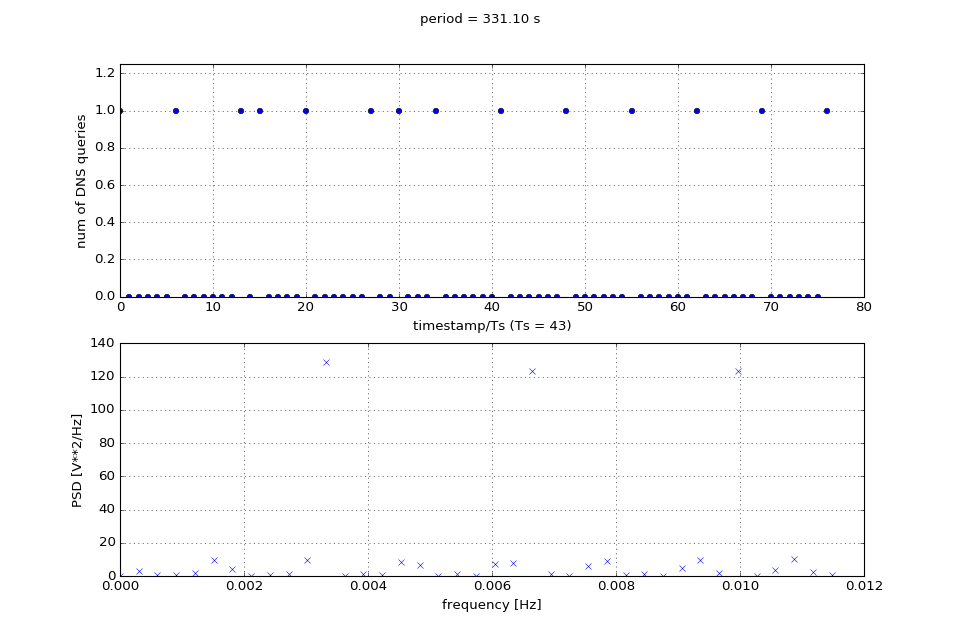

In [268]:
df_amz = df_try[df_try['qname']=='device-metrics-us.amazon.com']

time_arr = list( df_amz['timestamp'] )
dns_time = time_arr[-1] - time_arr[0]

x = np.array( list(df_amz['timestamp'] - time_arr[0]) )

Ts = int( min(x for x in np.diff(x)/2 if x > 1.0) )
fs = 1.0/Ts
print "Ts, fs = ", Ts, fs
            
y = np.bincount((x/Ts).astype(int))

f, Pxx_den = periodogram(y, fs)

max_el = max([(v,i) for i,v in enumerate(Pxx_den)])
period_freq = f[max_el[1]-1]
period = 1.0 / period_freq 

print "\tTs = ",Ts ,"; period_freq = ", period_freq, "; period = %.2f s"%period,"; dns_time/2 = ", dns_time/2

                
if PLOT_FIG:
    fig1, axarr = plt.subplots(2, figsize=(12,8))
    axarr[0].plot(range(len(y)), y, linestyle='None', marker='o', markersize=5)
    axarr[0].set_xlabel('timestamp/Ts (Ts = %.f)'%Ts)
    axarr[0].set_ylabel('num of DNS queries')
    axarr[0].set_ylim([0, max(y)+0.25])
    axarr[0].grid(True)

    axarr[1].plot(f, Pxx_den, linestyle='None', marker='x', markersize=5)
    axarr[1].set_xlabel('frequency [Hz]')
    axarr[1].set_ylabel('PSD [V**2/Hz]')
    axarr[1].grid(True)

    fig1.suptitle('period = ' + "%.2f s"%period)
    fig1.show()

In [279]:
p = get_period(df_try, '10.9.96.37')

srcIP =  10.9.96.37 ; qname =  2.android.pool.ntp.org ; tot_time =  3325.35639381 ; dns_time =  0.0 ; len(d) =  1
srcIP =  10.9.96.37 ; qname =  api.amazon.com ; tot_time =  3325.35639381 ; dns_time =  0.0 ; len(d) =  1
srcIP =  10.9.96.37 ; qname =  appconfig.hbonow.com ; tot_time =  3325.35639381 ; dns_time =  1441.99545789 ; len(d) =  2
srcIP =  10.9.96.37 ; qname =  content.hbonow.com ; tot_time =  3325.35639381 ; dns_time =  1442.215101 ; len(d) =  2
srcIP =  10.9.96.37 ; qname =  device-metrics-us.amazon.com ; tot_time =  3325.35639381 ; dns_time =  3300.04911494 ; len(d) =  14
	Ts =  43 ; period_freq =  0.00302023557838 ; period = 331.10 s ; dns_time/2 =  1650.02455747
	save fig to ../results/periodogram/split_hour_00000_20170206235900/10.9.96.37_device-metrics-us.amazon.com.png
srcIP =  10.9.96.37 ; qname =  dp-rsm-prod.amazon.com ; tot_time =  3325.35639381 ; dns_time =  0.0 ; len(d) =  1
srcIP =  10.9.96.37 ; qname =  ecx.images-amazon.com ; tot_time =  3325.35639381 ; dns_ti

## Try on all 2k+ IPs

In [ ]:
for srcIP in df_wireless.index:
    
    df_dev = df_b[df_b['srcIP']==srcIP]
    
    get_period(df_dev, srcIP)

srcIP =  10.8.0.150 ; tot_time =  3474.11486197
	qname =  clients2.google.com ; dns_time =  0.0 ; len(d) =  1
	qname =  clients4.google.com ; dns_time =  1800.13275003 ; len(d) =  2
	qname =  crl.microsoft.com ; dns_time =  2563.32992911 ; len(d) =  2
	qname =  safebrowsing-cache.google.com ; dns_time =  1836.39165902 ; len(d) =  2
	qname =  safebrowsing.google.com ; dns_time =  1836.40503502 ; len(d) =  2
	qname =  settings-win.data.microsoft.com ; dns_time =  1800.50399208 ; len(d) =  2
	qname =  stannum-sub.azurewebsites.net ; dns_time =  0.0 ; len(d) =  1
	qname =  vortex-win.data.microsoft.com ; dns_time =  1800.5034821 ; len(d) =  2
	qname =  www.google.com ; dns_time =  3448.07045126 ; len(d) =  21
		Ts =  2 ; period_freq =  0.0197101449275 ; period = 50.74 s ; dns_time/2 =  1724.03522563
		save fig to ../results/periodogram/split_hour_00000_20170206235900/10.8.0.150_www.google.com.png

	qname =  www.microsoft.com ; dns_time =  3439.00903988 ; len(d) =  54
		Ts =  7 ; period_fre